# Notebook to train and test U-Net on TCD_ML

## Install Prereqs

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow_datasets
!pip install matplotlib
!pip install pillow
!pip install pydot
!pip install pydotplus
!pip install graphviz

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 278 kB 9.4 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl

## Imports and Configs

In [9]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping

dataset_path = '../Data/Dataset/Predicted_Depth_Grayscale/'
map_path = '../PreprocessedImages/'
models_path = '../Models/'
model_name = 'SCD_Error_Correction_Faces'
training_data = 'Training/'
val_data = 'Testing/'

## Check GPU Running and Configs

From [here](https://github.com/tensorflow/tensorflow/issues/43174#issuecomment-691657692)

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CONFIGS

In [1]:
TRAINSET_SIZE = len(os.listdir(dataset_path + training_data))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
VALSET_SIZE = len(os.listdir(dataset_path + val_data))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")


# DATASET PARAMETERS
SEED = 123
TRAIN_LENGTH = TRAINSET_SIZE
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# MODEL PARAMETERS
OUTPUT_CHANNELS = 5

# TRAINING PARAMETERS
EPOCHS = 200
VAL_SUBSPLITS = 5 # CURRENTLY UNUSED
VALIDATION_STEPS = VALSET_SIZE//BATCH_SIZE//VAL_SUBSPLITS # CURRENTLY UNUSED


NameError: name 'os' is not defined

## Define Helper Functions (parse image, normalize, load image for train or test, display image)

In [15]:
def parse_image(img_path: str) -> dict:
    """
    Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=1, dtype=tf.dtypes.uint8)
    print(img_path)

    mask_path = tf.strings.regex_replace(img_path, 'Predicted', 'Original')
    
    print(mask_path)
#    mask_path = tf.strings.regex_replace(mask_path, '_SCD_Encoded', '_SCD_Encoded_Beta_Map')
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.dtypes.float32)

    return {'image': image, 'segmentation_mask': mask}

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    ### Don't resize, crop instead! :^) 
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)
#    input_image = tf.image.resize(datapoint['image'], (128, 128))
#    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_mask = add_gaussian_blur(input_mask)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)
#    input_image = tf.image.resize(datapoint['image'], (128, 128))
#    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_mask = add_gaussian_blur(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def add_gaussian_blur(image):
    image = tf.expand_dims(image, 0)
    blur = [tf.divide(tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype = tf.float32), 16.0)]
    blur = tf.expand_dims(blur, axis = -1)
    blur = tf.transpose(blur, [1,2,3,0])
    blurred_image = tf.nn.conv2d(image, blur, strides = (1,1), padding = 'SAME')[0]
    return blurred_image

## Define Helper Functions for displaying images and creating mask

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Depth', 'Predicted Depth', 'Abs Decoded Diff', 'Abs Predicted Diff']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        # plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], pred_mask[0], np.abs(image[0] * 255 - mask[0]), np.abs(pred_mask[0] - mask[0])])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        None

## Setup Training and Validation Datasets

In [27]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.png", seed=SEED)
val_dataset = val_dataset.map(parse_image)

dataset = {"train": train_dataset, "val": val_dataset}

train = dataset['train'].map(load_image_train)
test = dataset['val'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)


## Retrieve and display sample image

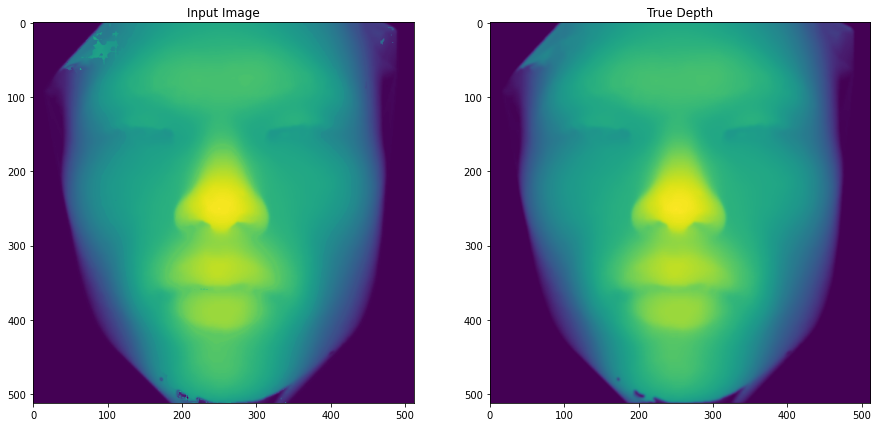

In [18]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

## Create Model Function

In [22]:
from tensorflow import Tensor

# https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
def relu_bn(inputs: Tensor) -> Tensor:
    relu = tf.keras.layers.ReLU()(inputs)
    bn = tf.keras.layers.BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = tf.keras.layers.Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = tf.keras.layers.Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = tf.keras.layers.Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = tf.keras.layers.Add()([x, y])
    out = relu_bn(out)
    return out

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[512, 512, 1])
    
    n_filt = 50
    filt_size = (3,3)
    
    x = inputs
    y = inputs
    z = inputs
    
    # BLOCK 1 - ORIGINAL SCALE
    conv1_x = tf.keras.layers.Conv2D(n_filt, filt_size, strides = 1, padding = 'same', activation = 'relu')
    conv2_x = tf.keras.layers.Conv2D(n_filt, filt_size, strides = 1, padding = 'same', activation = 'relu')
    
    x = conv1_x(x)
    x = residual_block(x, downsample = False, filters = n_filt, kernel_size = 3)
    x = conv2_x(x)
    
    # BLOCK 2 - 1/2 SCALE
    conv1_y = tf.keras.layers.Conv2D(n_filt, filt_size, strides = 1, padding = 'same', activation = 'relu')
    max_pool_y = tf.keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same')
    upsample_y = tf.keras.layers.UpSampling2D((2,2))
    conv2_y = tf.keras.layers.Conv2D(n_filt, filt_size, strides = 1, padding = 'same', activation = 'relu')
    
    y = conv1_y(y)
    y = max_pool_y(y)
    y = residual_block(y, downsample = False, filters = n_filt, kernel_size = 3)
    y = upsample_y(y)
    y = conv2_y(y)
    
    # BLOCK 3 - 1/4 SCALE
    conv1_z = tf.keras.layers.Conv2D(n_filt, filt_size, strides = 1, padding = 'same', activation = 'relu')
    max_pool_z = tf.keras.layers.MaxPool2D((4,4), strides = 4, padding = 'same')
    upsample_1_z = tf.keras.layers.UpSampling2D((2,2))
    upsample_2_z = tf.keras.layers.UpSampling2D((2,2))
    conv2_z = tf.keras.layers.Conv2D(n_filt, filt_size, strides = 1, padding = 'same', activation = 'relu')
    
    z = conv1_z(z)
    z = max_pool_z(z)
    z = residual_block(z, downsample = False, filters = n_filt, kernel_size = 3)
    z = upsample_1_z(z)
    z = upsample_2_z(z)
    z = conv2_z(z)
    
    # CONCATENATE AND OUTPUT
    concat = tf.keras.layers.Concatenate()
    conv_last = tf.keras.layers.Conv2D(1, filt_size, strides = 1, padding = 'same', activation = 'relu')
    x = concat([x, y, z])
    
    x = conv_last(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

## Create model

In [23]:
model = unet_model(OUTPUT_CHANNELS)
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(optimizer=optimizer, loss = 'mse', metrics=['accuracy', 'RootMeanSquaredError'])

#model.compile(optimizer='adam', loss= 'mse', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Show current predictions

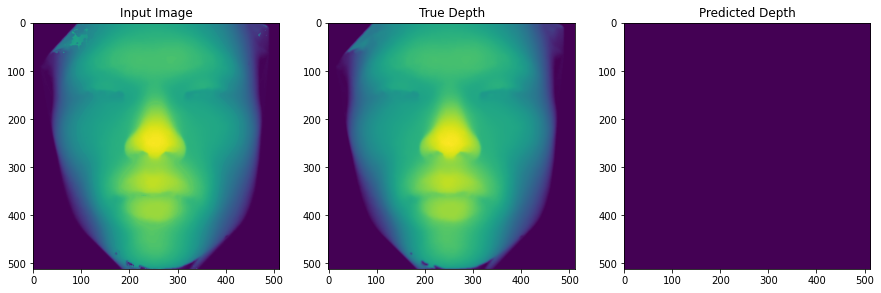

<PrefetchDataset shapes: ((None, 512, 512, 1), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 512, 512, 1), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [24]:
show_predictions()
print(train_dataset)
print(test_dataset)

## Fit dataset and show new predictions

In [29]:
checkpoint_path = '../Models/tmp/checkpoint'
es = EarlyStopping(monitor = 'val_loss', mode ='min', verbose = 1, patience = 5)
lrs = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, cooldown = 5)
chkpt = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', mode = 'min', save_best_only = True, save_weights_only = True)

model_history = model.fit(train_dataset, validation_data = test_dataset, epochs=EPOCHS, callbacks = [lrs, chkpt])
#model_history = model.fit(train_dataset, validation_data = test_dataset, epochs=EPOCHS, callbacks = es)

show_predictions(test_dataset, 3)

Epoch 1/200
115/115 [==============================] - 53s 462ms/step - loss: 1763.8929 - accuracy: 0.0027 - root_mean_squared_error: 41.9987 - val_loss: 8438.0078 - val_accuracy: 0.0018 - val_root_mean_squared_error: 91.8586
Epoch 2/200
115/115 [==============================] - 51s 445ms/step - loss: 55.9095 - accuracy: 0.1123 - root_mean_squared_error: 7.4773 - val_loss: 6906.0396 - val_accuracy: 0.0018 - val_root_mean_squared_error: 83.1026
Epoch 3/200
115/115 [==============================] - 52s 453ms/step - loss: 55.8886 - accuracy: 0.1730 - root_mean_squared_error: 7.4759 - val_loss: 5049.6050 - val_accuracy: 0.0018 - val_root_mean_squared_error: 71.0606
Epoch 4/200
115/115 [==============================] - 53s 457ms/step - loss: 51.6142 - accuracy: 0.1818 - root_mean_squared_error: 7.1843 - val_loss: 2094.9951 - val_accuracy: 0.0018 - val_root_mean_squared_error: 45.7711
Epoch 5/200
115/115 [==============================] - 53s 462ms/step - loss: 43.0905 - accuracy: 0.1828 

Epoch 37/200
115/115 [==============================] - 52s 451ms/step - loss: 18.0707 - accuracy: 0.1930 - root_mean_squared_error: 4.2510 - val_loss: 25.3849 - val_accuracy: 0.1781 - val_root_mean_squared_error: 5.0383
Epoch 38/200
115/115 [==============================] - 52s 451ms/step - loss: 15.0976 - accuracy: 0.1884 - root_mean_squared_error: 3.8856 - val_loss: 19.3472 - val_accuracy: 0.1781 - val_root_mean_squared_error: 4.3985
Epoch 39/200
115/115 [==============================] - 52s 451ms/step - loss: 12.8018 - accuracy: 0.1906 - root_mean_squared_error: 3.5780 - val_loss: 10.8109 - val_accuracy: 0.1781 - val_root_mean_squared_error: 3.2880
Epoch 40/200
115/115 [==============================] - 52s 448ms/step - loss: 12.8119 - accuracy: 0.1880 - root_mean_squared_error: 3.5794 - val_loss: 11.4277 - val_accuracy: 0.1786 - val_root_mean_squared_error: 3.3805
Epoch 41/200
115/115 [==============================] - 52s 451ms/step - loss: 14.3998 - accuracy: 0.1914 - root_mea

115/115 [==============================] - 52s 449ms/step - loss: 4.4965 - accuracy: 0.1899 - root_mean_squared_error: 2.1205 - val_loss: 8.8329 - val_accuracy: 0.1789 - val_root_mean_squared_error: 2.9720
Epoch 112/200
115/115 [==============================] - 52s 449ms/step - loss: 4.6851 - accuracy: 0.1898 - root_mean_squared_error: 2.1645 - val_loss: 8.8289 - val_accuracy: 0.1789 - val_root_mean_squared_error: 2.9713
Epoch 113/200
115/115 [==============================] - 52s 450ms/step - loss: 4.5996 - accuracy: 0.1946 - root_mean_squared_error: 2.1447 - val_loss: 8.8493 - val_accuracy: 0.1789 - val_root_mean_squared_error: 2.9748
Epoch 114/200
115/115 [==============================] - 52s 454ms/step - loss: 4.4407 - accuracy: 0.1895 - root_mean_squared_error: 2.1073 - val_loss: 8.7966 - val_accuracy: 0.1789 - val_root_mean_squared_error: 2.9659
Epoch 115/200
115/115 [==============================] - 52s 450ms/step - loss: 4.5561 - accuracy: 0.1884 - root_mean_squared_error: 2

KeyboardInterrupt: 

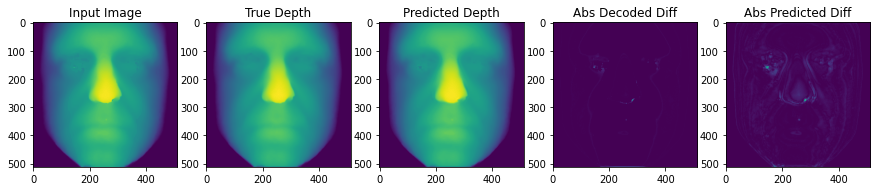

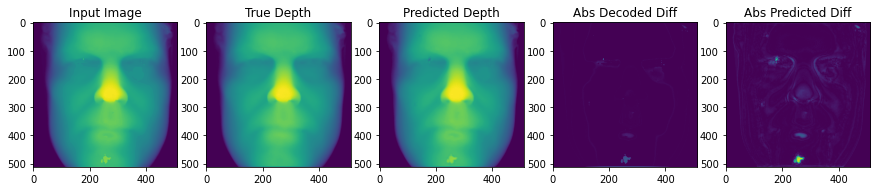

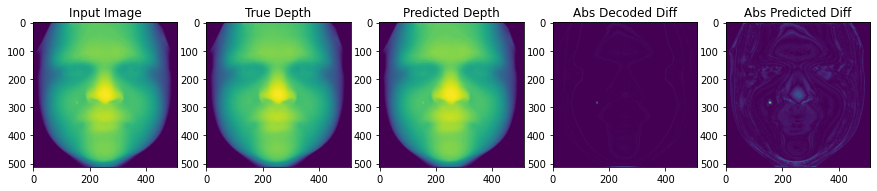

In [30]:
model.load_weights(checkpoint_path)
show_predictions(test_dataset, 3)

## Save Best Model

In [31]:
model.load_weights(checkpoint_path)
model.save(models_path + model_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/SCD_Error_Correction_Faces/assets
